--- 1. การโหลดข้อมูลและการเชื่อมต่อ (Database Connection) ---
โหลดข้อมูลสำเร็จ. จำนวนแถว: 768, จำนวนคอลัมน์: 9
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

--- 2.0. การวิเคราะห์ข้อมูล: Target Distribution (สัดส่วนข้อมูล) ---


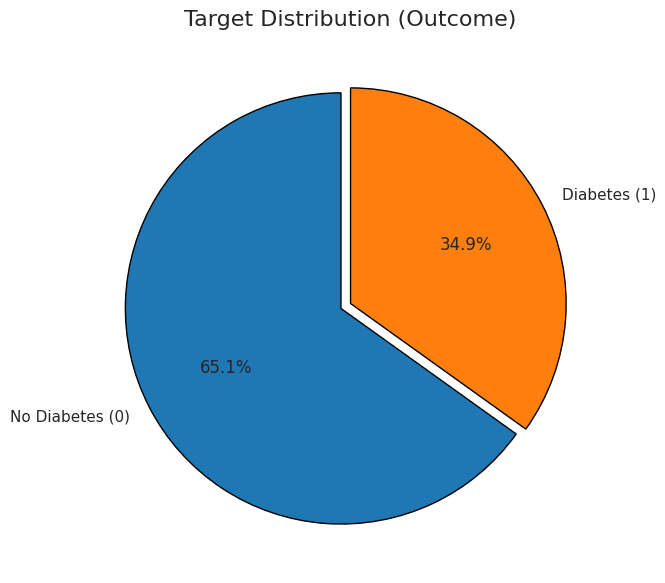


--- 2. การวิเคราะห์ข้อมูล: แผนภาพความสัมพันธ์ (Correlation Heatmap) ---


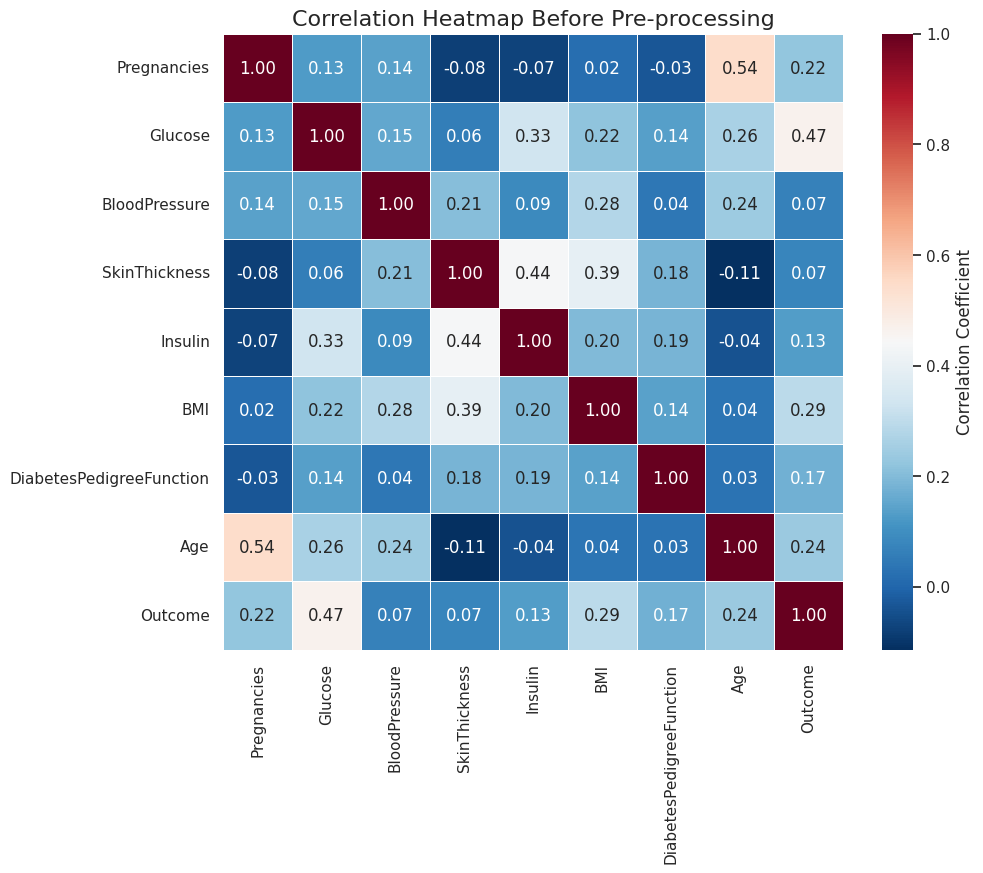


--- 2.1. การตรวจสอบค่า '0' (Missing Value Check) ---
⚠️ หมายเหตุ: ชุดข้อมูลนี้ค่า '0' ในคอลัมน์เหล่านี้ถือเป็น Missing Value

Standard NaN Check (ค่าที่หายไปตามปกติ):
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Detailed '0' Value Check (จำนวนค่า '0' ที่ต้องแก้ไข):
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Percentage of '0' values (เปอร์เซ็นต์ที่ต้องแก้ไข):
Glucose           0.65%
BloodPressure     4.56%
SkinThickness    29.56%
Insulin           48.7%
BMI               1.43%
dtype: object

--- 3. การเตรียมข้อมูลและการปรับมาตราส่วน (Pre-Processing & Scaling) ---

3.1 จัดการ Missing Values (แทน 0 ด้วย Median) เรียบร้อยแล้ว
3.2 แบ่งข้อมูลเป็น Train (80%): (614, 8) และ Test (20%

/tmp/ipython-input-3699771772.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace(0, df[col].median(), inplace=True)



--- Model: K-Nearest Neighbors (KNN) ---
Accuracy: 0.6883 | ROC AUC: 0.7709
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       100
           1       0.57      0.44      0.50        54

    accuracy                           0.69       154
   macro avg       0.65      0.63      0.64       154
weighted avg       0.68      0.69      0.68       154


**สรุป: โมเดลที่มีประสิทธิภาพดีที่สุด (วัดจาก AUC) คือ: Logistic Regression (LR)**

--- 6. การปรับจูนโมเดลและผลลัพธ์สุดท้าย (Fine-Tune Parameters & Final Result) ---
6.1 เริ่มการปรับจูนบนโมเดล Logistic Regression (LR)...

- พารามิเตอร์ที่ดีที่สุด (Best Parameters): {'C': 0.1, 'solver': 'liblinear'}
- ค่า AUC สุดท้าย: 0.8148 (เทียบกับ AUC ที่ดีที่สุดเดิม: 0.8174)
- ความแม่นยำสุดท้าย (Final Accuracy): 0.7078


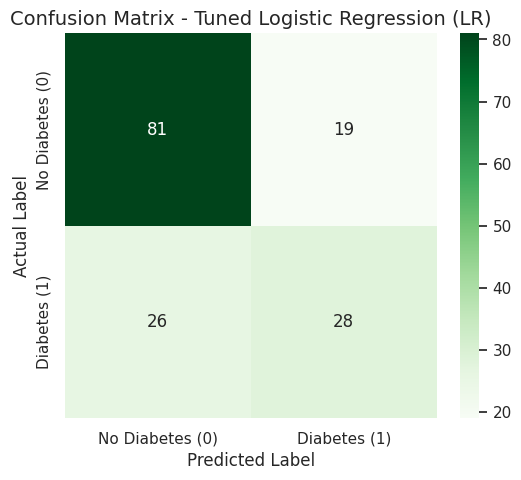

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
# เพิ่มโค้ดสำหรับปรับสไตล์กราฟเพื่อให้ Target Distribution ดูสวยงามขึ้น
sns.set_theme(style="whitegrid")


print("--- 1. การโหลดข้อมูลและการเชื่อมต่อ (Database Connection) ---")
df = pd.read_csv('diabetes.csv')
print(f"โหลดข้อมูลสำเร็จ. จำนวนแถว: {df.shape[0]}, จำนวนคอลัมน์: {df.shape[1]}")
print(df.head())

# --- ปรับเป็น Pie Chart: Target Distribution Graph เข้ามาตรงนี้ ---
print("\n--- 2.0. การวิเคราะห์ข้อมูล: Target Distribution (สัดส่วนข้อมูล) ---")
target_counts = df['Outcome'].value_counts()
labels = ['No Diabetes (0)', 'Diabetes (1)']
colors = ['#1f77b4', '#ff7f0e'] # สีฟ้าสำหรับ 0, สีส้มสำหรับ 1
explode = [0.05, 0] # เน้นชิ้นส่วน 'No Diabetes' เล็กน้อย

plt.figure(figsize=(7, 7))
plt.pie(target_counts,
        labels=labels,
        autopct='%1.1f%%', # แสดงเป็นเปอร์เซ็นต์ทศนิยม 1 ตำแหน่ง
        startangle=90,
        colors=colors,
        explode=explode,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1})
plt.title('Target Distribution (Outcome)', fontsize=16)
plt.show()
# ------------------------------------------------------------------

print("\n--- 2. การวิเคราะห์ข้อมูล: แผนภาพความสัมพันธ์ (Correlation Heatmap) ---")
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='RdBu_r', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap Before Pre-processing', fontsize=16)
plt.show()

cols_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print("\n--- 2.1. การตรวจสอบค่า '0' (Missing Value Check) ---")
print("⚠️ หมายเหตุ: ชุดข้อมูลนี้ค่า '0' ในคอลัมน์เหล่านี้ถือเป็น Missing Value")
print("\nStandard NaN Check (ค่าที่หายไปตามปกติ):")
print(df.isnull().sum())
print("\nDetailed '0' Value Check (จำนวนค่า '0' ที่ต้องแก้ไข):")
missing_zeros = df[cols_to_replace].eq(0).sum()
print(missing_zeros)
data_size = len(df)
missing_percentage = (missing_zeros / data_size) * 100
print("\nPercentage of '0' values (เปอร์เซ็นต์ที่ต้องแก้ไข):")
print(missing_percentage.round(2).astype(str) + '%')

print("\n--- 3. การเตรียมข้อมูลและการปรับมาตราส่วน (Pre-Processing & Scaling) ---")
for col in cols_to_replace:
    df[col].replace(0, df[col].median(), inplace=True)
print("\n3.1 จัดการ Missing Values (แทน 0 ด้วย Median) เรียบร้อยแล้ว")

X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"3.2 แบ่งข้อมูลเป็น Train (80%): {X_train.shape} และ Test (20%): {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("3.3 ปรับมาตราส่วนข้อมูลด้วย StandardScaler เสร็จสมบูรณ์")

print("\n--- 4. Future Engineering: การสร้างตัวแปรดัชนีความเสี่ยง (Risk Index) ---")
X_train_fe = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_fe = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 1. High_Risk_Index (ตัวเดิมที่คุณมี)
X_train_fe['High_Risk_Index'] = (X_train_fe['Glucose'] * 0.4) + (X_train_fe['BMI'] * 0.3) + (X_train_fe['Age'] * 0.3)
X_test_fe['High_Risk_Index'] = (X_test_fe['Glucose'] * 0.4) + (X_test_fe['BMI'] * 0.3) + (X_test_fe['Age'] * 0.3)

# 2. BMI Squared (ตัวที่เพิ่ม #1)
X_train_fe['BMI2'] = X_train_fe['BMI'] ** 2
X_test_fe['BMI2'] = X_test_fe['BMI'] ** 2

# 3. Glucose to BMI Ratio (ตัวที่เพิ่ม #2)
X_train_fe['Glucose_BMI_Ratio'] = X_train_fe['Glucose'] / X_train_fe['BMI']
X_test_fe['Glucose_BMI_Ratio'] = X_test_fe['Glucose'] / X_test_fe['BMI']

# 4. Age * BMI Interaction (ตัวที่เพิ่ม #3)
X_train_fe['Age_BMI'] = X_train_fe['Age'] * X_train_fe['BMI']
X_test_fe['Age_BMI'] = X_test_fe['Age'] * X_test_fe['BMI']


X_train_final = X_train_fe.values
X_test_final = X_test_fe.values

print(f"สร้างคุณลักษณะ 'High_Risk_Index' และอีก 3 ตัวแปรเพิ่มสำเร็จ. จำนวนคุณลักษณะทั้งหมด: {X_train_final.shape[1]}")

print("\n--- 5. การประเมินโมเดล: เปรียบเทียบ 3 โมเดล ---")

models = {
    'Logistic Regression (LR)': LogisticRegression(random_state=42),
    'Decision Tree (DT)': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors (KNN)': KNeighborsClassifier(n_neighbors=9)
}

results = {}
best_model_name = ''
best_auc = 0

for name, model in models.items():
    model.fit(X_train_final, y_train)
    y_pred = model.predict(X_test_final)
    y_proba = model.predict_proba(X_test_final)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results[name] = {'Accuracy': acc, 'AUC': auc}

    print(f"\n--- Model: {name} ---")
    print(f"Accuracy: {acc:.4f} | ROC AUC: {auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    if auc > best_auc:
        best_auc = auc
        best_model_name = name

print(f"\n**สรุป: โมเดลที่มีประสิทธิภาพดีที่สุด (วัดจาก AUC) คือ: {best_model_name}**")
best_model = models[best_model_name]

print("\n--- 6. การปรับจูนโมเดลและผลลัพธ์สุดท้าย (Fine-Tune Parameters & Final Result) ---")

print(f"6.1 เริ่มการปรับจูนบนโมเดล {best_model_name}...")

if best_model_name == 'Logistic Regression (LR)':
    param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
    model_to_tune = LogisticRegression(random_state=42)
elif best_model_name == 'Decision Tree (DT)':
    param_grid = {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]}
    model_to_tune = DecisionTreeClassifier(random_state=42)
else:
    param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
    model_to_tune = KNeighborsClassifier()

grid_search = GridSearchCV(model_to_tune, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_final, y_train)

final_model = grid_search.best_estimator_

y_pred_final = final_model.predict(X_test_final)
y_proba_final = final_model.predict_proba(X_test_final)[:, 1]
final_auc = roc_auc_score(y_test, y_proba_final)

print(f"\n- พารามิเตอร์ที่ดีที่สุด (Best Parameters): {grid_search.best_params_}")
print(f"- ค่า AUC สุดท้าย: {final_auc:.4f} (เทียบกับ AUC ที่ดีที่สุดเดิม: {best_auc:.4f})")
print(f"- ความแม่นยำสุดท้าย (Final Accuracy): {accuracy_score(y_test, y_pred_final):.4f}")

cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Diabetes (0)', 'Diabetes (1)'],
            yticklabels=['No Diabetes (0)', 'Diabetes (1)'])
plt.title(f'Confusion Matrix - Tuned {best_model_name}', fontsize=14)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()